# Uso do XGboost na deteção de fraudes em transações de Cartões de Crédito

Este é um projeto pessoal que faz parte dos meus estudos em Data Science, utilizando Python para análise e modelagem de dados.

O conjunto de dados está disponível no Kaggle e refere-se a transações realizadas com cartões de crédito em setembro de 2013 por titulares de cartões europeus, ocorrendo ao longo de dois dias.

***objetivo deste projeto é construir um modelo preditivo, utilizando o algoritmo XGBoost***, que, de maneira o mais precisa possível, consiga identificar se uma transação é suspeita de fraude ou não. O dataset contém apenas variáveis numéricas de entrada, que resultam de uma transformação por Análise de Componentes Principais (PCA). As características, como V1, V2, ..., V28, representam os principais componentes extraídos pelo PCA, sendo que os dados originais não estão disponíveis. Em razão disso, informações adicionais sobre as características não podem ser fornecidas.

O dataset original pode ser acessado no Kaggle através do seguinte link:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

# Métricas

Como estamos lidando com um problema de classificação binária, as métricas utilizadas para avaliar o desempenho do modelo serão: a matriz de confusão configurada com o padrão de normalização 'pred', de modo que os valores serão apresentados em forma de porcentagem relativa ao total de valores na classe real. Isso permite visualizar a relação de valores previstos corretamente, falsos positivos e falsos negativos. Além disso, utilizaremos a Área Sob a Curva de Precisão-Recall (AUPRC) e a Área Sob a Curva ROC (AUC-ROC) para avaliar o desempenho do modelo, especialmente em cenários de desbalanceamento de classes. Por fim, o método classification_report será utilizado para a avaliação de métricas adicionais.

# Dicionário de Variáveis

- ***V1, V2, …, V28:*** Componentes principais obtidos através da transformação PCA. Estes são valores numéricos que representam as variáveis originais após a redução de dimensionalidade com PCA.

- ***Time***: Tempo, em segundos, decorrido entre cada transação e a primeira transação no dataset.

- ***Amount***: Valor da transação. Esta variável pode ser usada em modelos de aprendizado que consideram custos sensíveis ao exemplo.

- ***Class***: Variável de resposta, indicando se a transação é fraudulenta. Assume valor 1 em caso de fraude e 0 caso contrário.

# Instalação e Importações

Nesta seção, serão realizadas as instalações e importações dos módulos e bibliotecas necessárias para o projeto. Devido a problemas na versão 1.6.0 do scikit-learn, que impedia a criação correta das pipelines, neste projeto foram utilizadas as seguintes versões específicas das bibliotecas:

- scikit-learn versão 1.5.2
- xgboost versão 2.1.3
- numpy 1.26.4
- pandas 2.2.3
- matplotlib 3.10.0

Essas versões foram escolhidas para garantir o funcionamento adequado das funcionalidades necessárias.

In [607]:
import numpy as np # Manipulação de Dados
import pandas as pd
import seaborn as sns  

import matplotlib.pyplot as plt # Plotagem dos Gráficos

import sklearn
from sklearn.base import clone
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay ,classification_report
from sklearn import metrics


import imblearn
from imblearn.over_sampling import SMOTE

import xgboost # Algoritmo usado para a Classificação Binária
from xgboost import XGBClassifier

# Funções Utilizadas no Projeto

In [608]:
def calcula_prevalencia(y_actual):
    '''
    Calcula e exibe a prevalência da classe positiva em um conjunto de rótulos reais.
    '''
    print(f'Prevalência da classe não nula (1): {sum(y_actual) * 100/ len(y_actual):.3f}%')


def calcula_valores_validos(df):
    '''
    Calcula e exibe a porcentagem de valores nulos ou faltantes em cada coluna do DataFrame apenas se existirem.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado. 
    '''
    valores_exibidos = 0
    for col in df.columns:
        soma_nulos = sum(df[col].isnull() | df[col].isna())
        if soma_nulos > 0 :
            print(f'Valores Nulos em {col}: {soma_nulos * 100/ len(df[col]):.3f}%')
            valores_exibidos += 1
    if valores_exibidos == 0:
        print('Nenhum valor nulo ou faltante encontrado no DataFrame.')


def verifica_balanceamento(df, coluna_alvo):
    '''
    Verifica o balanceamento das classes em uma coluna alvo de um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    coluna_alvo (str): O nome da coluna alvo que contém as classes.
    '''
    contagem_classes = df[coluna_alvo].value_counts()
    proporcao_classes = df[coluna_alvo].value_counts(normalize=True) * 100
    balanceamento = pd.DataFrame({'Contagem': contagem_classes, 'Proporção (%)': np.round(proporcao_classes, 2)})
    print(balanceamento)


def verifica_coluna_constante(df):
    '''
    Verifica se há colunas constantes (com o mesmo valor em todas as linhas) em um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    colunas_constantes = [col for col in df.columns if df[col].nunique() == 1]
    if colunas_constantes:
        print(f'Colunas constantes encontradas: {colunas_constantes}')
    else:
        print('Nenhuma coluna constante encontrada.')


def validacao_cruzada(
    modelo, 
    X, 
    y,
    metric, 
    oversampler=None, 
    n_splits=5,
    shuffle=False,
    prediction_method="predict_proba",
    random_state=None
):

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # Clona modelo (CRÍTICO)
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling só no treino
        if oversampler:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        modelo_fold.fit(X_train, y_train)

        if prediction_method == "predict_proba":
            y_pred = modelo_fold.predict_proba(X_test)[:, 1]
        elif prediction_method == "predict":
            y_pred = modelo_fold.predict(X_test)
        else:
            raise ValueError("prediction_method deve ser 'predict' ou 'predict_proba'")

        score = metric(y_test, y_pred)
        scores.append(score)

        print(f"Fold {fold + 1}: {metric.__name__} = {score:.4f}")

    print(f"\nScore médio: {np.mean(scores):.4f}")
    print(f"Desvio padrão: {np.std(scores):.4f}")

    return scores


# Carregando e Compreensão dos Dados

In [609]:
df_data = pd.read_csv('data/processed/creditcard.csv')

In [610]:
df_data.shape

(284807, 31)

In [611]:
df_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [612]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [613]:
df_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [614]:
calcula_valores_validos(df_data)

Nenhum valor nulo ou faltante encontrado no DataFrame.


In [615]:
verifica_balanceamento(df_data, 'Class')

       Contagem  Proporção (%)
Class                         
0        284315          99.83
1           492           0.17


In [616]:
verifica_coluna_constante(df_data)

Nenhuma coluna constante encontrada.


## Verificação de Correlação

In [ ]:
corr_matrix = df_data.drop(columns=['Class']).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
strong_corr = corr_matrix.mask(np.abs(corr_matrix) <= 0.5)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    strong_corr, 
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 9},
    vmin=-1, vmax=1
)

plt.title("Heatmap - Correlações Fortes (>0.5 ou <-0.5)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Existe um grande desbalanceamento entre as classes, mas decidimos testar o modelo dessa forma, pois o viés resultante pode não ser tão relevante. Além disso, o grande volume de dados pode compensar esse desbalanceamento, minimizando o impacto no desempenho do modelo.

## Seleção de Atributos

In [ ]:
df_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df_data['Class'].nunique() > 1

True

In [ ]:
# Lista dos atributos que serão utilizados como entrada (Não constantes e diferentes da classe alvo)
atributos = [x for x in df_data.columns if (df_data[f'{x}'].nunique() > 1 and x != 'Class')]

In [ ]:
atributos

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

# Criação das Funções para a Pipeline

In [ ]:
class PipeSteps(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns
          
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]
    
class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler() 
        self.scaler.fit(X[self.columns])
        return self
        
    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X


# V 1.0 - Modelo Vanila

## Criação do Pipeline de Aprendizado de Máquina

In [ ]:
pipe_prepropcessamento = Pipeline([('feature_selection', SelecionaColunas(atributos)),
                                       ('standard_scaling', PadronizaDados(atributos))])

In [ ]:
pipe_prepropcessamento

Pipeline(steps=[('feature_selection',
                 SelecionaColunas(columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5',
                                           'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                                           'V12', 'V13', 'V14', 'V15', 'V16',
                                           'V17', 'V18', 'V19', 'V20', 'V21',
                                           'V22', 'V23', 'V24', 'V25', 'V26',
                                           'V27', 'V28', 'Amount'])),
                ('standard_scaling',
                 PadronizaDados(columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5',
                                         'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                                         'V12', 'V13', 'V14', 'V15', 'V16',
                                         'V17', 'V18', 'V19', 'V20', 'V21',
                                         'V22', 'V23', 'V24', 'V25', 'V26',
                                         'V27', 'V28', 'Amount']))])

In [ ]:
pipe_final = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('learning', XGBClassifier(random_state = 42, 
                               eval_metric = 'aucpr', 
                               objective = 'binary:logistic') )
])

## Preparação dos Dados

In [ ]:
X = df_data[atributos]
y = df_data['Class']
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Treinamento e Avaliação do Modelo

### Cross Validation

In [ ]:
scores_f1 = validacao_cruzada(
    modelo=pipe_final,
    X=X_treino,
    y=y_treino,
    metric=f1_score,
    prediction_method="predict",
    oversampler=None,
    n_splits=5,
    shuffle=True
)

Fold 1: f1_score = 0.8130
Fold 2: f1_score = 0.8527
Fold 3: f1_score = 0.8702
Fold 4: f1_score = 0.8682
Fold 5: f1_score = 0.8837

Score médio: 0.8576
Desvio padrão: 0.0244


### Treinamento

In [ ]:
pipe_final.fit(X_treino, y_treino)


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_selection',
                                  SelecionaColunas(columns=['Time', 'V1', 'V2',
                                                            'V3', 'V4', 'V5',
                                                            'V6', 'V7', 'V8',
                                                            'V9', 'V10', 'V11',
                                                            'V12', 'V13', 'V14',
                                                            'V15', 'V16', 'V17',
                                                            'V18', 'V19', 'V20',
                                                            'V21', 'V22', 'V23',
                                                            'V24', 'V25', 'V26',
                                                            'V27', 'V28',
                                                            'Amount'])),
                                 ('standard_scaling',
                                  PadronizaDados(columns=['Time', 'V1', 'V2',
                                                          'V3', 'V4', 'V5',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Avaliação Teste

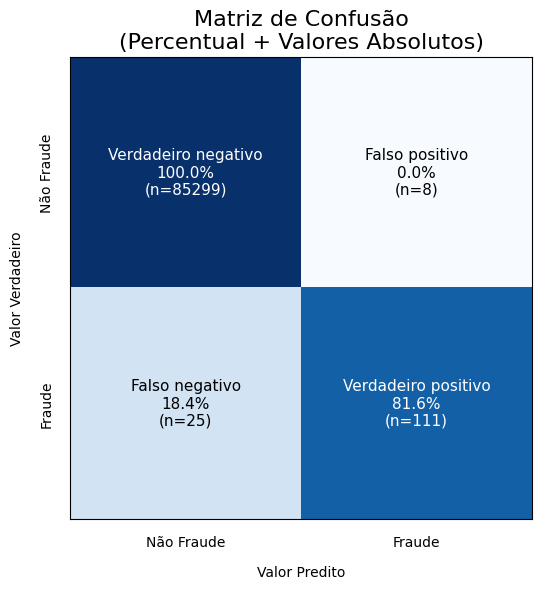

In [ ]:
# Calcular as previsões no conjunto de treino
proba_teste = pipe_final.predict_proba(X_teste)[:, 1]
pred_teste = pipe_final.predict(X_teste)

# Calcular a matriz de confusão normalizada
cm_norm = confusion_matrix(y_teste, pred_teste, normalize='true')
cm_abs = confusion_matrix(y_teste, pred_teste)
fig, ax1 = plt.subplots(figsize=(9, 6))
im = ax1.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Matriz de Confusão\n(Percentual + Valores Absolutos)', fontsize=16)

# Ajuste dos labels 
# Ajusta os lables do eixo x
ax1.set_xlabel('Valor Predito')
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.tick_params(axis='x', labelsize=14)

# Ajusta os lables do eixo y
ax1.set_ylabel('Valor Verdadeiro')
ax1.yaxis.set_label_coords(-0.1, 0.5) 
ax1.tick_params(axis='y', labelsize=14) 

# Retita a faixa laterla
plt.xticks([])
plt.yticks([])

# Adiciona as legenda usadas para a tabela
ax1.text(0.25, -0.05, 'Não Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(0.75, -0.05, 'Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.75, 'Não Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.25, 'Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)

# Loop
thresh = cm_norm.max() / 2

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):

        percentual = cm_norm[i, j] * 100
        absoluto = cm_abs[i, j]

        texto = (
            f"{'Verdadeiro' if i == j else 'Falso'} "
            f"{'negativo' if j == 0 else 'positivo'}\n"
            f"{percentual:.1f}%\n"
            f"(n={absoluto})"
        )

        ax1.text(
            j, i, texto,
            ha="center",
            va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=11
        )


In [ ]:
# AUPRC
precision, recall, _ = precision_recall_curve(y_teste, proba_teste)
auprc = auc(recall, precision)

# AUC-ROC
roc_auc = roc_auc_score(y_teste, proba_teste)

# Relatório de classificação 
report = classification_report(y_teste, pred_teste)

print(f'AUPRC: {auprc:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')
print(report)

AUPRC: 0.889
ROC_AUC: 0.986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



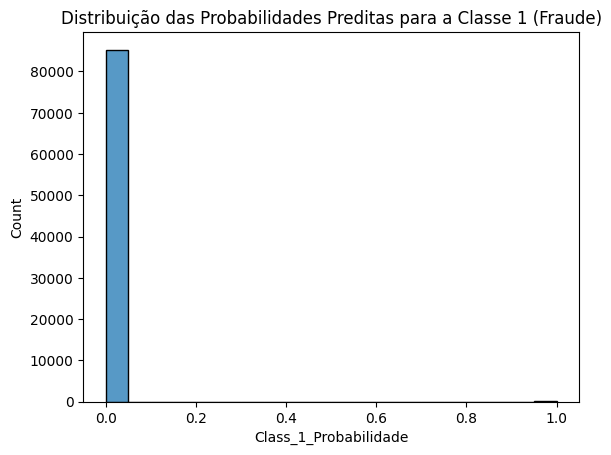

In [ ]:
df_probabilidades = pd.DataFrame(proba_teste,  
                                 columns=["Class_1_Probabilidade"])
                                    

plt.title('Distribuição das Probabilidades Preditas para a Classe 1 (Fraude)', 
          fontsize=12)

sns.histplot(
    data=df_probabilidades,
    x="Class_1_Probabilidade",
    binwidth=0.05
)

plt.show()

# V 1.5 - Modelo com scale_pos_weight

## Criação do Pipeline de Aprendizado de Máquina

In [ ]:
# Nova Pipeline

n_positivos = y_treino.sum()
n_negativos = len(y_treino) - n_positivos

scale_pos_weight = n_negativos / n_positivos

pipe_final_v_1_5 = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('learning', XGBClassifier(
        random_state = 42, 
        eval_metric = 'aucpr', 
        objective = 'binary:logistic', 
        scale_pos_weight=scale_pos_weight) )
        ])

## Treinamento e Avaliação do Modelo

### Cross Validation

In [ ]:
scores_f1 = validacao_cruzada(
    modelo=pipe_final_v_1_5,
    X=X_treino,
    y=y_treino,
    metric=f1_score,
    prediction_method="predict",
    oversampler=None,
    n_splits=5,
    shuffle=True
)


Fold 1: f1_score = 0.8702
Fold 2: f1_score = 0.8406
Fold 3: f1_score = 0.8905
Fold 4: f1_score = 0.8485
Fold 5: f1_score = 0.8189

Score médio: 0.8537
Desvio padrão: 0.0247


### Treinamento

In [ ]:
pipe_final_v_1_5.fit(X_treino, y_treino)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_selection',
                                  SelecionaColunas(columns=['Time', 'V1', 'V2',
                                                            'V3', 'V4', 'V5',
                                                            'V6', 'V7', 'V8',
                                                            'V9', 'V10', 'V11',
                                                            'V12', 'V13', 'V14',
                                                            'V15', 'V16', 'V17',
                                                            'V18', 'V19', 'V20',
                                                            'V21', 'V22', 'V23',
                                                            'V24', 'V25', 'V26',
                                                            'V27', 'V28',
                                                            'Amount'])),
                                 ('standard_scaling',
                                  PadronizaDados(columns=['Time', 'V1', 'V2',
                                                          'V3', 'V4', 'V5',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Avaliação Teste

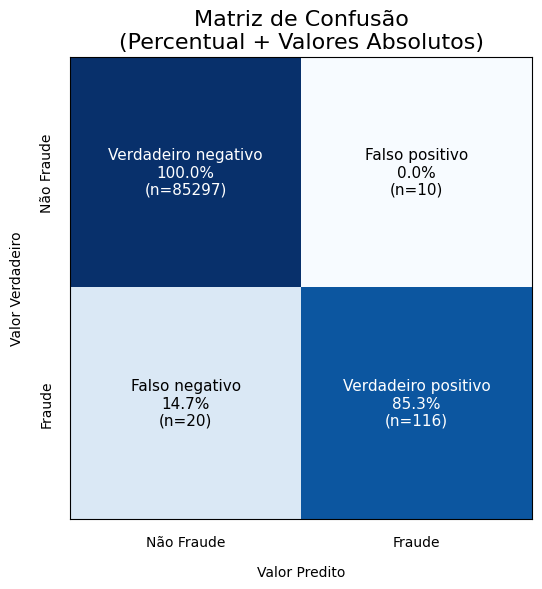

In [ ]:
# Calcular as previsões no conjunto de treino
proba_teste = pipe_final_v_1_5.predict_proba(X_teste)[:, 1]
pred_teste = pipe_final_v_1_5.predict(X_teste)

# Calcular a matriz de confusão normalizada
cm_norm = confusion_matrix(y_teste, pred_teste, normalize='true')
cm_abs = confusion_matrix(y_teste, pred_teste)

fig, ax1 = plt.subplots(figsize=(9, 6))
im = ax1.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Matriz de Confusão\n(Percentual + Valores Absolutos)', fontsize=16)

# Ajuste dos labels 
# Ajusta os lables do eixo x
ax1.set_xlabel('Valor Predito')
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.tick_params(axis='x', labelsize=14)

# Ajusta os lables do eixo y
ax1.set_ylabel('Valor Verdadeiro')
ax1.yaxis.set_label_coords(-0.1, 0.5) 
ax1.tick_params(axis='y', labelsize=14) 

# Retita a faixa laterla
plt.xticks([])
plt.yticks([])

# Adiciona as legenda usadas para a tabela
ax1.text(0.25, -0.05, 'Não Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(0.75, -0.05, 'Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.75, 'Não Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.25, 'Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)

# Loop
thresh = cm_norm.max() / 2

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):

        percentual = cm_norm[i, j] * 100
        absoluto = cm_abs[i, j]

        texto = (
            f"{'Verdadeiro' if i == j else 'Falso'} "
            f"{'negativo' if j == 0 else 'positivo'}\n"
            f"{percentual:.1f}%\n"
            f"(n={absoluto})"
        )

        ax1.text(
            j, i, texto,
            ha="center",
            va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=11
        )


In [ ]:
# AUPRC
precision, recall, _ = precision_recall_curve(y_teste, proba_teste)
auprc = auc(recall, precision)


# AUC-ROC
roc_auc = roc_auc_score(y_teste, proba_teste)

# Relatório de classificação 
report = classification_report(y_teste, pred_teste)

print(f'AUPRC: {auprc:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')
print(report)

AUPRC: 0.905
ROC_AUC: 0.987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.85      0.89       136

    accuracy                           1.00     85443
   macro avg       0.96      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443



# V 2.0 - Modelo com Oversampling

In [ ]:
pipe_final_v_2 = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('learning', XGBClassifier(random_state = 42, 
                               eval_metric = 'aucpr', 
                               objective = 'binary:logistic') )
])

## Treinamento e Avaliação do Modelo

### Cross Validation

In [ ]:
scores_f1 = validacao_cruzada(
    modelo=pipe_final_v_2,
    X=X_treino,
    y=y_treino,
    metric=f1_score,
    prediction_method="predict",
    oversampler=SMOTE(random_state=42),
    n_splits=5,
    shuffle=True
)


Fold 1: f1_score = 0.8112
Fold 2: f1_score = 0.8219
Fold 3: f1_score = 0.8175
Fold 4: f1_score = 0.8276
Fold 5: f1_score = 0.8489

Score médio: 0.8254
Desvio padrão: 0.0129


### Treinamento

In [ ]:
X_treino_smote, y_treino_smote = SMOTE(random_state=42).fit_resample(
    X_treino, y_treino
)

pipe_final_v_2.fit(X_treino_smote, y_treino_smote)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_selection',
                                  SelecionaColunas(columns=['Time', 'V1', 'V2',
                                                            'V3', 'V4', 'V5',
                                                            'V6', 'V7', 'V8',
                                                            'V9', 'V10', 'V11',
                                                            'V12', 'V13', 'V14',
                                                            'V15', 'V16', 'V17',
                                                            'V18', 'V19', 'V20',
                                                            'V21', 'V22', 'V23',
                                                            'V24', 'V25', 'V26',
                                                            'V27', 'V28',
                                                            'Amount'])),
                                 ('standard_scaling',
                                  PadronizaDados(columns=['Time', 'V1', 'V2',
                                                          'V3', 'V4', 'V5',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Avaliação Teste

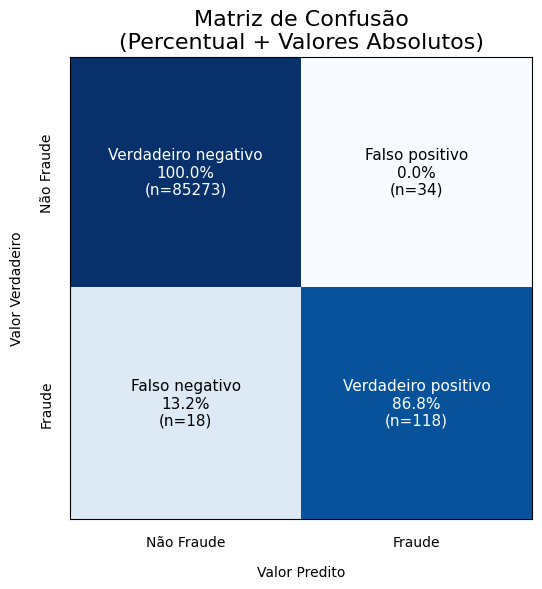

In [ ]:
# Calcular as previsões no conjunto de treino
proba_teste = pipe_final_v_2.predict_proba(X_teste)[:, 1]
pred_teste = pipe_final_v_2.predict(X_teste)

# Calcular a matriz de confusão normalizada
cm_norm = confusion_matrix(y_teste, pred_teste, normalize='true')
cm_abs = confusion_matrix(y_teste, pred_teste)

fig, ax1 = plt.subplots(figsize=(9, 6))
im = ax1.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Matriz de Confusão\n(Percentual + Valores Absolutos)', fontsize=16)

# Ajuste dos labels 
# Ajusta os lables do eixo x
ax1.set_xlabel('Valor Predito')
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.tick_params(axis='x', labelsize=14)

# Ajusta os lables do eixo y
ax1.set_ylabel('Valor Verdadeiro')
ax1.yaxis.set_label_coords(-0.1, 0.5) 
ax1.tick_params(axis='y', labelsize=14) 

# Retita a faixa laterla
plt.xticks([])
plt.yticks([])

# Adiciona as legenda usadas para a tabela
ax1.text(0.25, -0.05, 'Não Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(0.75, -0.05, 'Fraude', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.75, 'Não Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)
ax1.text(-0.05, 0.25, 'Fraude',rotation = 'vertical', ha='center', va='center', fontsize=10, color='black', transform=ax1.transAxes)

# Loop
thresh = cm_norm.max() / 2

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):

        percentual = cm_norm[i, j] * 100
        absoluto = cm_abs[i, j]

        texto = (
            f"{'Verdadeiro' if i == j else 'Falso'} "
            f"{'negativo' if j == 0 else 'positivo'}\n"
            f"{percentual:.1f}%\n"
            f"(n={absoluto})"
        )

        ax1.text(
            j, i, texto,
            ha="center",
            va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=11
        )


In [ ]:
# AUPRC
precision, recall, _ = precision_recall_curve(y_teste, proba_teste)
auprc = auc(recall, precision)


# AUC-ROC
roc_auc = roc_auc_score(y_teste, proba_teste)

# Relatório de classificação 
report = classification_report(y_teste, pred_teste)

print(f'AUPRC: {auprc:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')
print(report)

AUPRC: 0.884
ROC_AUC: 0.985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.78      0.87      0.82       136

    accuracy                           1.00     85443
   macro avg       0.89      0.93      0.91     85443
weighted avg       1.00      1.00      1.00     85443



# Comparação entre modelos

[WIP]

# Considerações Finais:

[WIP]

# Possibilidades de Ampliação

[WIP]